# Explore Schema
In this notebook, we will learn how to explore created schema!

In [ ]:
%%capture
!pip install dlt[duckdb]

In [ ]:
import dlt
from dlt.sources.helpers import requests
from google.colab import userdata
import os

os.environ["ACCESS_TOKEN"] = userdata.get('ACCESS_TOKEN')

BASE_URL = "https://api.github.com/repos/dlt-hub/dlt/issues"

def pagination(url, access_token):
    while True:
        response = requests.get(url, headers={"Authorization": f"Bearer {access_token}"})
        response.raise_for_status()
        yield response.json()

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(
    table_name="issues",
    write_disposition="replace",
    primary_key="id",
)
def get_issues(
    access_token=os.getenv("ACCESS_TOKEN")
):
    url = f"{BASE_URL}?per_page=100&sort=updated&directions=desc&state=open"
    yield pagination(url, access_token)


@dlt.source
def github_source(access_token=os.getenv("ACCESS_TOKEN")):
    return get_issues(access_token)


pipeline = dlt.pipeline(
    pipeline_name="github_issues",
    destination="duckdb",
    dataset_name="github_data",
)
load_info = pipeline.run(github_source())
print(load_info)

SecretNotFoundError: Secret ACCESS_TOKEN does not exist.

Data was loaded without fails, lackily, let's take a look behind the curtains!

# Schema

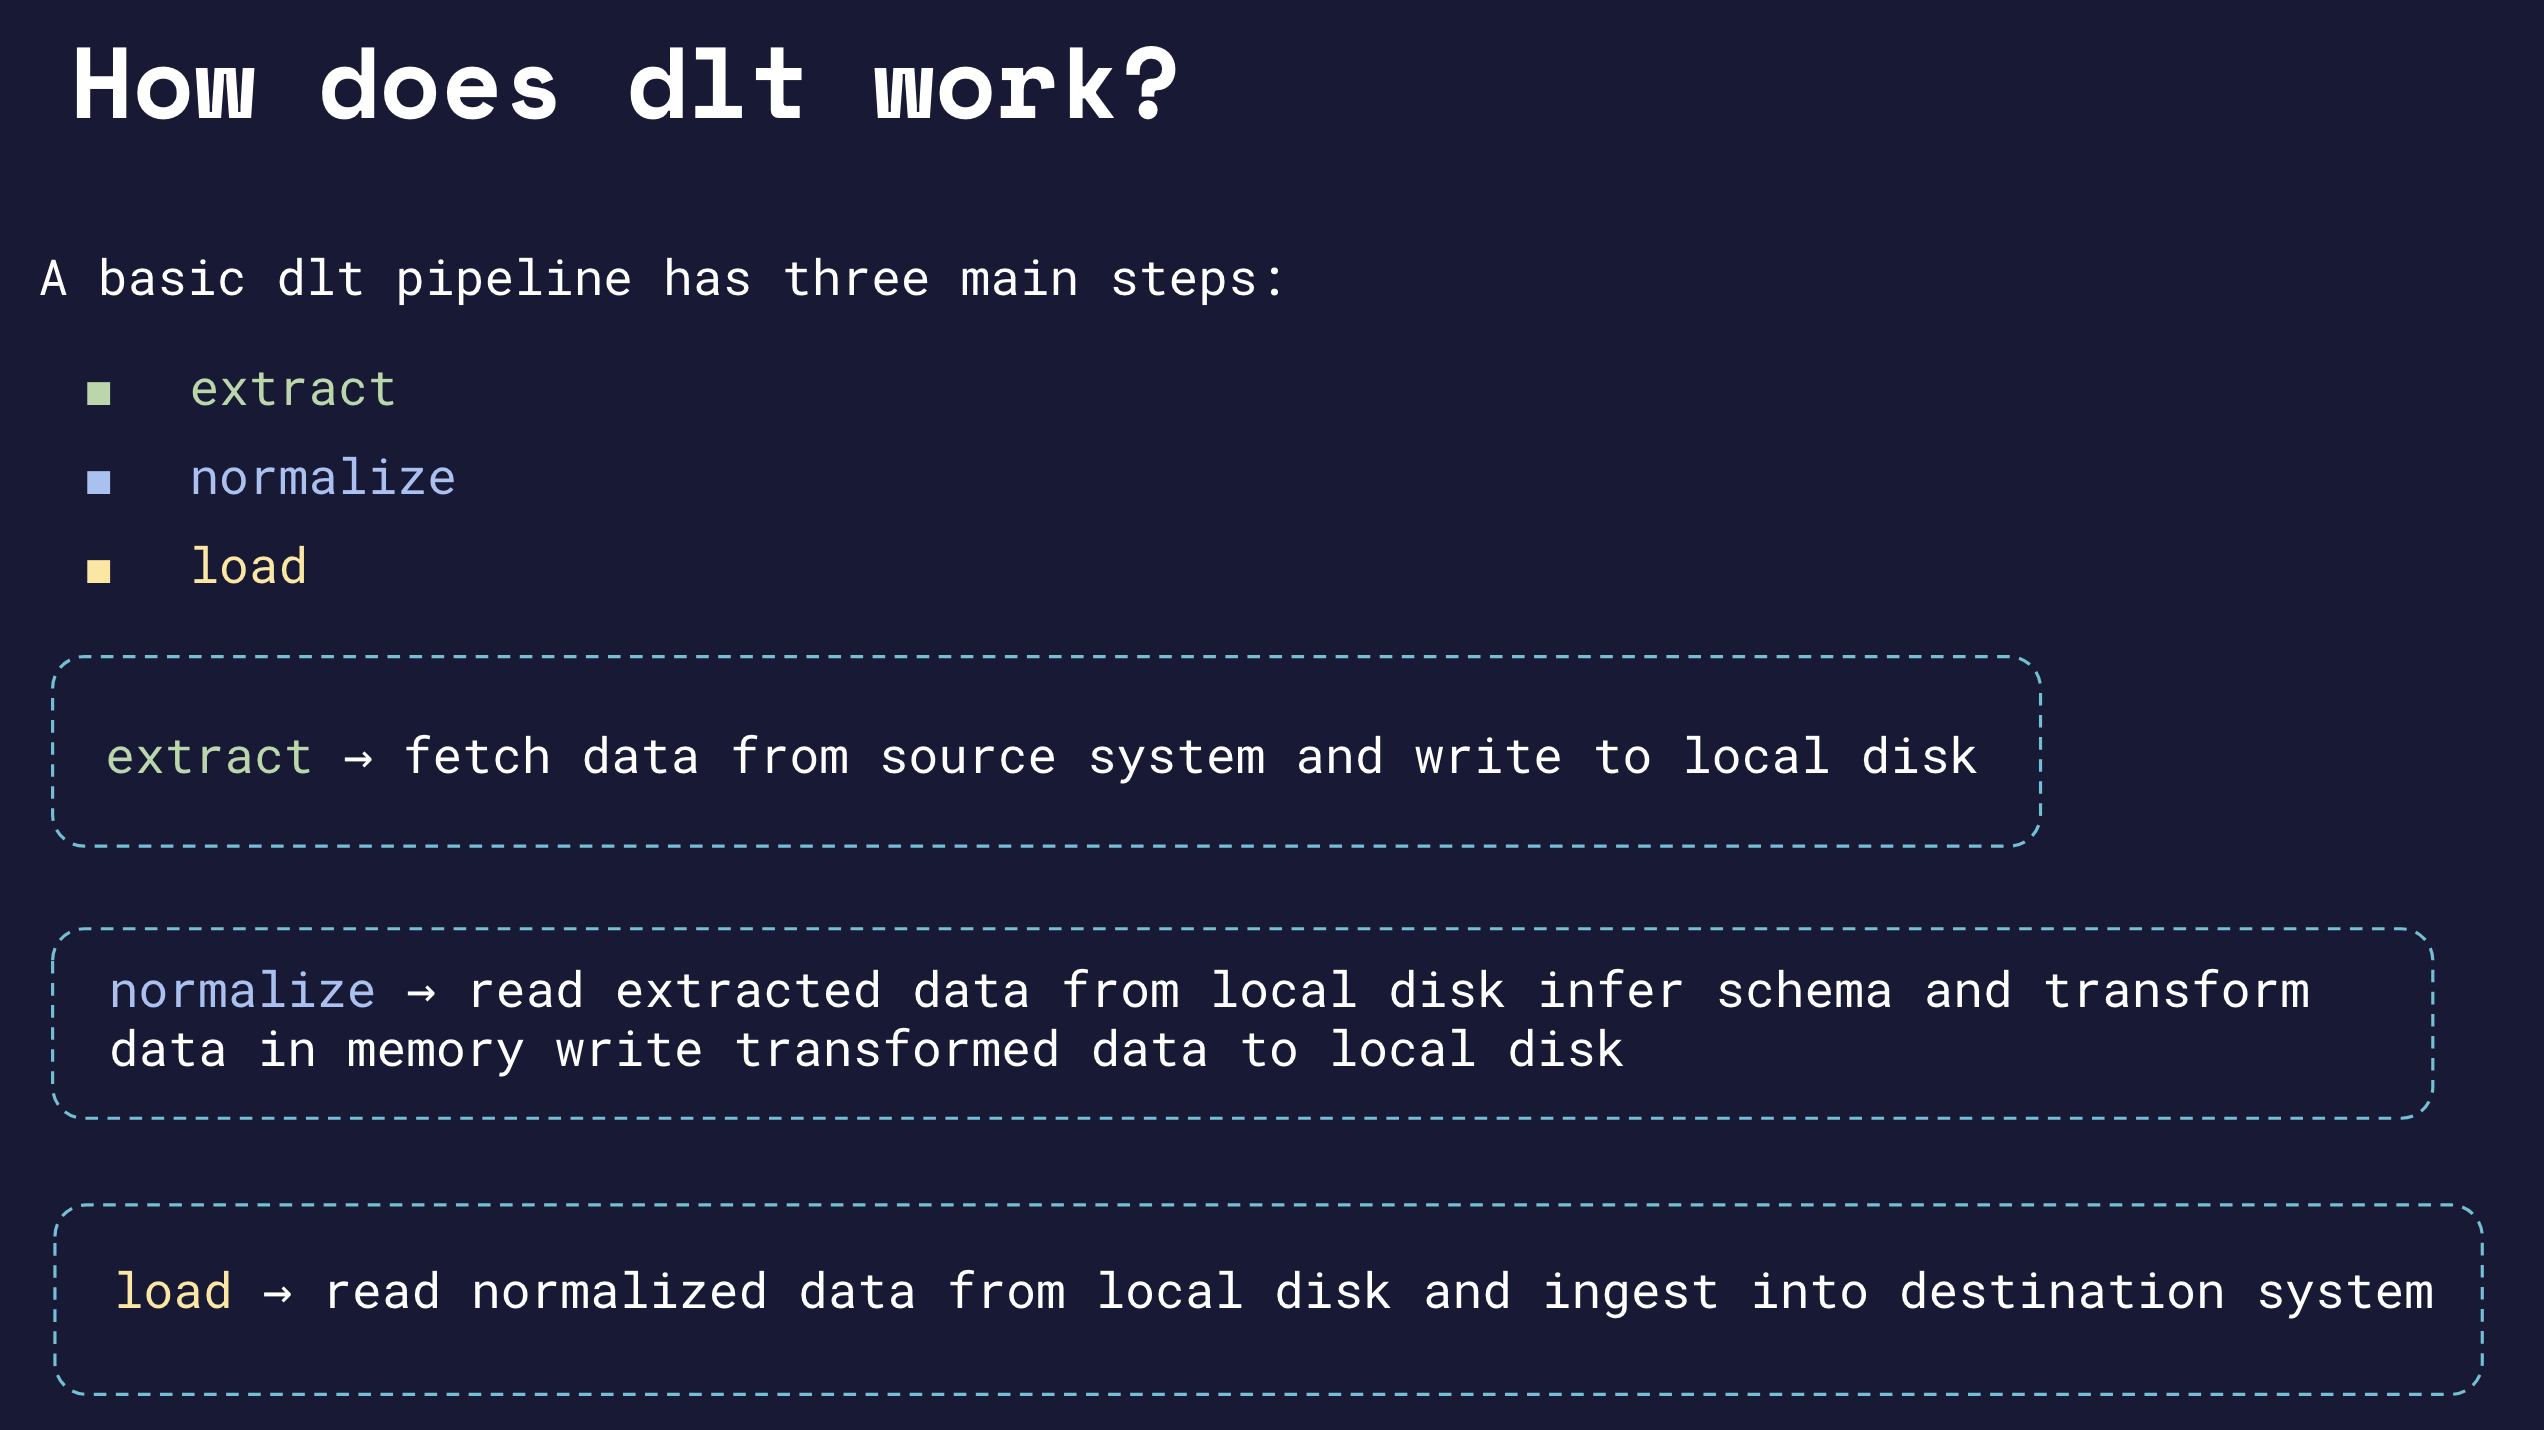

The schema describes the structure of normalized data (e.g. tables, columns, data types, etc.) and provides instructions on how the data should be processed and loaded.

dlt generates schemas from the data during the normalization process.

User can affect this standard behavior by providing hints that change how tables, columns and other metadata is generated and how the data is loaded. As you remember from the sources & resources part, such hints can be passed in the code ie. to `dlt.resource` decorator or `pipeline.run` method or via `apply_hints` function. Schemas can be also exported and imported as files, which can be directly modified.

💡 dlt associates a schema with a source and a table schema with a resource.

## Inspect schema

When you create and then run a pipeline, you may want to manually inspect and change the schema that dlt generated for you. Here's how you do it.


### CLI

To see the schema changes introduced in the package:


In [ ]:
!dlt pipeline -v github_issues load-package

Attaching to pipeline github_issues
Found pipeline github_issues in /var/dlt/pipelines
Package 1723734523.9134004 found in /var/dlt/pipelines/github_issues/load/loaded/1723734523.9134004
The package with load id 1723734523.9134004 for schema github_source is in LOADED state. It updated schema for 0 tables. The package was LOADED at 2024-08-15 15:08:51.092915+00:00.
Jobs details:
Job: issues__performed_via_github_app__events.382710f3be.insert_values, table: issues__performed_via_github_app__events in completed_jobs. File type: insert_values, size: 721B. Started on: 2024-08-15 15:08:46.253439+00:00 and completed in 4.84 seconds.
Job: issues__labels.d047a45058.insert_values, table: issues__labels in completed_jobs. File type: insert_values, size: 3.9K. Started on: 2024-08-15 15:08:46.247439+00:00 and completed in 4.85 seconds.
Job: issues__assignees.6382da513f.insert_values, table: issues__assignees in completed_jobs. File type: insert_values, size: 3.8K. Started on: 2024-08-15 15:08:46.2

### Python

In [ ]:
# load_info = pipeline.run(github_source())
all_attributes_methods = dir(load_info.load_packages[0].schema)
public_attributes_methods = [attr for attr in all_attributes_methods if not attr.startswith('_')]

print("Public attributes and methods with their types:")
for attr in public_attributes_methods:
    attr_value = getattr(load_info.load_packages[0].schema, attr)
    if callable(attr_value):
        print(f"{attr} (method)")
    else:
        print(f"{attr} (attribute)")

Public attributes and methods with their types:
ENGINE_VERSION (attribute)
add_type_detection (method)
apply_schema_contract (method)
clone (method)
coerce_row (method)
data_item_normalizer (attribute)
data_table_names (method)
data_tables (method)
dlt_table_names (method)
dlt_tables (method)
drop_tables (method)
expand_schema_contract_settings (method)
filter_row (method)
filter_row_with_hint (method)
from_dict (method)
from_stored_schema (method)
get_new_table_columns (method)
get_preferred_type (method)
get_table (method)
get_table_columns (method)
is_modified (attribute)
is_new (attribute)
is_new_table (method)
loads_table_name (attribute)
merge_hints (method)
name (attribute)
naming (attribute)
normalize_data_item (method)
previous_hashes (attribute)
remove_type_detection (method)
replace_schema_content (method)
resolve_contract_settings_for_table (method)
set_schema_contract (method)
settings (attribute)
state_table_name (attribute)
stored_version (attribute)
stored_version_hash 

In [ ]:
print(load_info.load_packages[0].schema.to_pretty_json())

{
  "version": 2,
  "version_hash": "H7ZTCSUvAVyngHGV7DtfpniPvV88MkuRWgRGoeJfPCY=",
  "engine_version": 9,
  "name": "github_source",
  "tables": {
    "_dlt_version": {
      "columns": {
        "version": {
          "data_type": "bigint",
          "nullable": false
        },
        "engine_version": {
          "data_type": "bigint",
          "nullable": false
        },
        "inserted_at": {
          "data_type": "timestamp",
          "nullable": false
        },
        "schema_name": {
          "data_type": "text",
          "nullable": false
        },
        "version_hash": {
          "data_type": "text",
          "nullable": false
        },
        "schema": {
          "data_type": "text",
          "nullable": false
        }
      },
      "write_disposition": "skip",
      "description": "Created by DLT. Tracks schema updates"
    },
    "_dlt_loads": {
      "columns": {
        "load_id": {
          "data_type": "text",
          "nullable": false
       

## Schema content hash and version
Each schema file contains content based hash `version_hash`:
```
{
  "version": 2,
  "version_hash": "I71VoNz/az2zWIuU4a/k/dBTHWAaiAJYf4o8RnJth04=",
  "engine_version": 9,
  "name": "github_source",
  "tables": {
       ....
```

that is used to:

- Detect manual changes to schema (ie. user edits content).
- Detect if the destination database schema is synchronized with the file schema.

Each time the schema is saved, the version hash is updated.

Each schema contains a numeric version which increases automatically whenever schema is updated and saved. Numeric version is meant to be human-readable. There are cases (parallel processing) where the order is lost.

💡 Schema in the destination is migrated if its hash is not stored in `_dlt_versions` table. In principle many pipelines may send data to a single dataset. If table name clash then a single table with the union of the columns will be created. If columns clash, and they have different types etc. then the load may fail if the data cannot be coerced.

## Data types

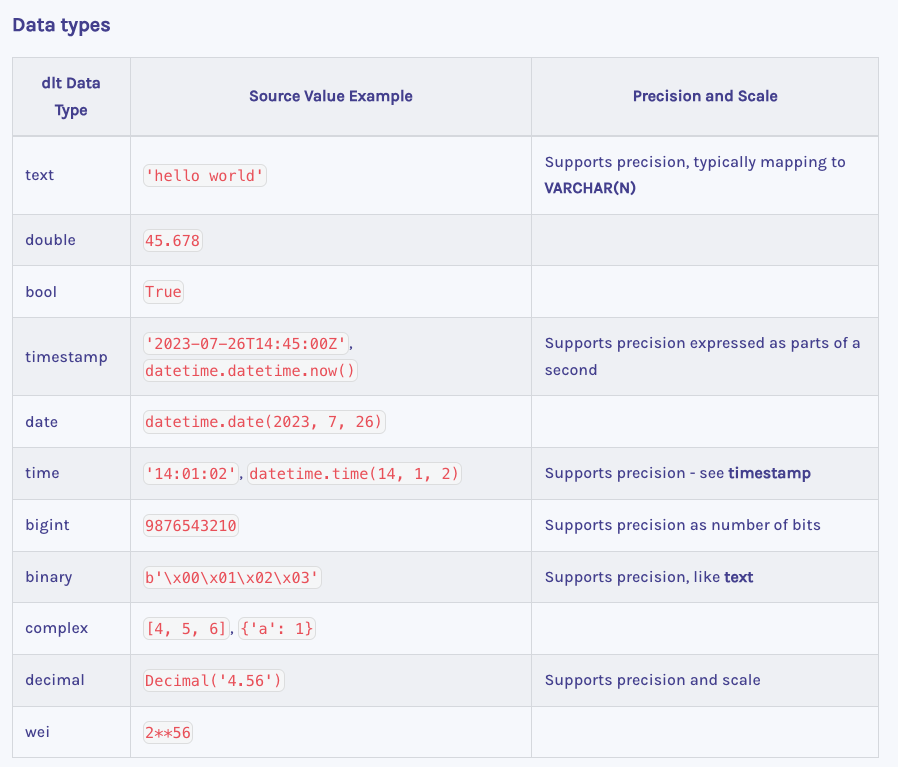

Change data types with Python:
```py
@dlt.resource(name="user", columns={"tags": {"data_type": "complex"}})
def get_users():
  ...
```

or `apply_hints`

```py
get_users.apply_hints(columns={"tags": {"data_type": "complex"}})
```



## Schema settings



```json
 "settings": {
    "detections": [
      "iso_timestamp"
    ],
    "default_hints": {
      "not_null": [
        "_dlt_id",
        "_dlt_root_id",
        "_dlt_parent_id",
        "_dlt_list_idx",
        "_dlt_load_id"
      ],
      "foreign_key": [
        "_dlt_parent_id"
      ],
      "root_key": [
        "_dlt_root_id"
      ],
      "unique": [
        "_dlt_id"
      ]
    }
  },
```

### Data type autodetectors

You can define a set of functions that will be used to infer the data type of the column from a value.

```toml
settings:
  detections:
    - timestamp
    - iso_timestamp
    - iso_date
    - large_integer
    - hexbytes_to_text
    - wei_to_double
```

### Column hint rules
You can define a global rules that will apply hints of a newly inferred columns.

```toml
settings:
  default_hints:
    foreign_key:
      - _dlt_parent_id
    not_null:
      - _dlt_id
      - _dlt_root_id
      - _dlt_parent_id
      - _dlt_list_idx
      - _dlt_load_id
    unique:
      - _dlt_id
    root_key:
      - _dlt_root_id
```

### Preferred data types
You can define rules that will set the data type for newly created columns.

```toml
settings:
  preferred_types:
    re:timestamp: timestamp
    inserted_at: timestamp
    created_at: timestamp
    updated_at: timestamp
```

Read more about [schema settings](https://dlthub.com/docs/general-usage/schema#schema-settings).

## Modify schema

### Import / Export schema

Set up an export folder by providing the `export_schema_path` argument to `dlt.pipeline` to save the schema. Set up an import folder from which dlt will read your modifications by providing `import_schema_path` argument.

Following our example in run a pipeline:

In [ ]:
pipeline = dlt.pipeline(
    import_schema_path="schemas/import",
    export_schema_path="schemas/export",
    pipeline_name="github_issues",
    destination="duckdb",
    dataset_name="github_data",
)
load_info = pipeline.run(github_source())
print(load_info)

2024-08-15 15:09:04,349|[WARNING]|28866|132855464394752|dlt|schema_storage.py|_maybe_import_schema:147|Schema github_source was present in schema storage at /var/dlt/pipelines/github_issues/schemas but will be overwritten with imported schema version 3 and imported hash LeY1S3gGyUqHd1alKkk3gKHXJobnmxp0QAV4FXN+Cpg=
2024-08-15 15:09:04,353|[WARNING]|28866|132855464394752|dlt|schema_storage.py|_maybe_import_schema:154|Schema github_source in schema storage contains tables (issues, issues__labels, issues__assignees, issues__performed_via_github_app__events) that are present in the destination. If you changed schema of those tables in import schema, consider using one of the refresh options: https://dlthub.com/devel/general-usage/pipeline#refresh-pipeline-data-and-state


Pipeline github_issues load step completed in 1.26 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_issues.duckdb location to store data
Load package 1723734545.869294 is LOADED and contains no failed jobs


The following folder structure in the project root folder will be created:

```
schemas
    |---import/
    |---export/
```

Rather than providing the paths in the `dlt.pipeline` function, you can also set them in the in `config.toml` file:
```
export_schema_path="schemas/export"
import_schema_path="schemas/import"
```

#### How importing a schema works

1. When a new pipeline is created and the source function is extracted for the first time, a new schema is added to the pipeline. This schema is created out of global hints and resource hints present in the source extractor function.
2. Every such new schema will be saved to the import folder (if it does not exist there already) and used as the initial version for all future pipeline runs.
3. Once a schema is present in import folder, it is writable by the user only.
4. Any changes to the schemas in that folder are detected and propagated to the pipeline automatically on the next run. It means that after a user update, the schema in import folder reverts all the automatic updates from the data.

>**CAUTION**
>
>dlt will not modify tables after they are created. So if you have a yaml file, and you change it (e.g. change a data type or add a hint), then you need to delete the dataset or set `dev_mode=True`




#### Change the data type

Let's change the schema and look what happens. For example, change data type of "number" column in "issues" table from `bigint` to `double`.

In [ ]:
pipeline = dlt.pipeline(
    import_schema_path="schemas/import",
    export_schema_path="schemas/export",
    pipeline_name="github_issues1",
    destination="duckdb",
    dataset_name="github_data",
)
load_info = pipeline.run(github_source())
print(load_info)

2024-08-15 15:11:45,163|[WARNING]|28866|132855464394752|dlt|schema_storage.py|_maybe_import_schema:147|Schema github_source was present in schema storage at /var/dlt/pipelines/github_issues1/schemas but will be overwritten with imported schema version 4 and imported hash i/wkaB9EggreeFvgIifVTeTOonBgDo4f2pEKKDyns4E=
2024-08-15 15:11:45,165|[WARNING]|28866|132855464394752|dlt|schema_storage.py|_maybe_import_schema:154|Schema github_source in schema storage contains tables (issues, issues__labels, issues__assignees, issues__performed_via_github_app__events) that are present in the destination. If you changed schema of those tables in import schema, consider using one of the refresh options: https://dlthub.com/devel/general-usage/pipeline#refresh-pipeline-data-and-state


Pipeline github_issues1 load step completed in 1.17 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_issues1.duckdb location to store data
Load package 1723734706.300078 is LOADED and contains no failed jobs


In [ ]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database 'chess_pipeline.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
stats_table = conn.sql("SELECT number FROM issues LIMIT 5").df()
display(stats_table)

,number
0,1700
1,1696
2,1695
3,1699
4,1697
